# Pass Rush Collision Feature Engineering
## Big Data Bowl 2023 - Building Collision Features for Pressure Prediction

**Goal**: Engineer collision dynamics features from tracking data to predict QB pressure events.

**Approach**: Similar to punt analytics collision intensity features:
- Calculate rusher-QB proximity over time
- Compute closing speeds and acceleration
- Engineer collision intensity metrics
- Add play context features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Load Data

In [2]:
print("Loading datasets...")

# Load tracking data (start with week 1)
week1 = pd.read_csv('nfl-big-data-bowl-2023/week1.csv')
plays = pd.read_csv('nfl-big-data-bowl-2023/plays.csv')
pff = pd.read_csv('nfl-big-data-bowl-2023/pffScoutingData.csv')
players = pd.read_csv('nfl-big-data-bowl-2023/players.csv')

print(f"✅ Loaded {len(week1):,} tracking records")
print(f"✅ Loaded {len(plays):,} plays")
print(f"✅ Loaded {len(pff):,} PFF records")

# Create target variable
rushers = pff[pff['pff_role'] == 'Pass Rush'].copy()
rushers['generated_pressure'] = (
    (rushers['pff_hit'] == 1) |
    (rushers['pff_hurry'] == 1) |
    (rushers['pff_sack'] == 1)
).astype(int)

print(f"\n✅ {len(rushers):,} rush attempts")
print(f"✅ {rushers['generated_pressure'].sum():,} pressure events ({rushers['generated_pressure'].mean()*100:.2f}%)")

Loading datasets...
✅ Loaded 1,118,122 tracking records
✅ Loaded 8,557 plays
✅ Loaded 188,254 PFF records

✅ 36,362 rush attempts
✅ 4,232 pressure events (11.64%)


## 2. Define Collision Feature Calculation Functions

Based on the punt analytics collision validation approach.

In [3]:
def calculate_rusher_qb_features(rusher_tracking, qb_tracking):
    """
    Calculate collision features between a rusher and QB.
    Similar to punt analytics collision_features calculation.
    
    Returns dict of features or None if insufficient data.
    """
    
    # Need at least 3 frames for both players
    if len(rusher_tracking) < 3 or len(qb_tracking) < 3:
        return None
    
    # Find common frames
    rusher_tracking = rusher_tracking.sort_values('frameId').copy()
    qb_tracking = qb_tracking.sort_values('frameId').copy()
    
    common_frames = set(rusher_tracking['frameId']).intersection(set(qb_tracking['frameId']))
    
    if len(common_frames) < 3:
        return None
    
    # Filter to common frames
    rusher_common = rusher_tracking[rusher_tracking['frameId'].isin(common_frames)].sort_values('frameId')
    qb_common = qb_tracking[qb_tracking['frameId'].isin(common_frames)].sort_values('frameId')
    
    # Merge on frameId
    merged = rusher_common.merge(qb_common, on='frameId', suffixes=('_rusher', '_qb'))
    
    if len(merged) < 3:
        return None
    
    # Calculate distances
    merged['distance'] = np.sqrt(
        (merged['x_rusher'] - merged['x_qb'])**2 + 
        (merged['y_rusher'] - merged['y_qb'])**2
    )
    
    features = {}
    
    # ==================== DISTANCE FEATURES ====================
    features['min_distance'] = merged['distance'].min()
    features['avg_distance'] = merged['distance'].mean()
    features['distance_at_start'] = merged['distance'].iloc[0]
    features['distance_at_end'] = merged['distance'].iloc[-1]
    
    # Find closest approach
    min_dist_idx = merged['distance'].idxmin()
    closest_frame = merged.loc[min_dist_idx]
    features['frame_at_closest'] = closest_frame['frameId']
    
    # ==================== SPEED FEATURES ====================
    features['rusher_max_speed'] = merged['s_rusher'].max()
    features['rusher_avg_speed'] = merged['s_rusher'].mean()
    features['rusher_speed_at_closest'] = closest_frame['s_rusher']
    
    features['qb_max_speed'] = merged['s_qb'].max()
    features['qb_avg_speed'] = merged['s_qb'].mean()
    features['qb_speed_at_closest'] = closest_frame['s_qb']
    
    # ==================== ACCELERATION FEATURES ====================
    features['rusher_max_accel'] = merged['a_rusher'].max()
    features['rusher_avg_accel'] = merged['a_rusher'].mean()
    features['rusher_accel_at_closest'] = closest_frame['a_rusher']
    
    features['qb_max_accel'] = merged['a_qb'].max()
    features['qb_avg_accel'] = merged['a_qb'].mean()
    features['qb_accel_at_closest'] = closest_frame['a_qb']
    
    # ==================== RELATIVE MOTION ====================
    # Combined speed at closest approach
    features['combined_speed_at_closest'] = (
        closest_frame['s_rusher'] + closest_frame['s_qb']
    )
    
    # Closing speed (rate of distance decrease)
    distance_change = np.gradient(merged['distance'])
    features['max_closing_speed'] = -np.min(distance_change)  # Negative = getting closer
    features['avg_closing_speed'] = -np.mean(distance_change[distance_change < 0]) if any(distance_change < 0) else 0
    
    # ==================== ORIENTATION/DIRECTION ====================
    # Angle between rusher and QB at closest approach
    dx = closest_frame['x_qb'] - closest_frame['x_rusher']
    dy = closest_frame['y_qb'] - closest_frame['y_rusher']
    approach_angle = np.degrees(np.arctan2(dy, dx))
    
    features['approach_angle'] = approach_angle
    features['rusher_orientation_at_closest'] = closest_frame['o_rusher']
    features['qb_orientation_at_closest'] = closest_frame['o_qb']
    
    # Angle difference (head-on vs side approach)
    rusher_angle_diff = abs(closest_frame['o_rusher'] - approach_angle)
    features['rusher_angle_alignment'] = min(rusher_angle_diff, 360 - rusher_angle_diff)
    
    # ==================== TEMPORAL FEATURES ====================
    features['time_to_closest_approach'] = closest_frame['frameId'] / 10.0  # Convert frames to seconds (10 fps)
    features['total_frames'] = len(merged)
    features['play_duration'] = features['total_frames'] / 10.0
    
    # ==================== COLLISION INTENSITY (KEY FEATURE) ====================
    # Similar to punt analytics: combines proximity and speed
    # Higher values = more dangerous collision potential
    
    min_dist_norm = 1 / (features['min_distance'] + 0.1)  # Inverse distance (closer = higher)
    speed_norm = features['combined_speed_at_closest']  # Raw combined speed
    
    features['collision_intensity_raw'] = min_dist_norm * speed_norm
    
    # Additional intensity metric: closing speed weighted by proximity
    features['weighted_closing_speed'] = features['max_closing_speed'] / (features['min_distance'] + 1.0)
    
    return features

print("✅ Feature calculation functions defined")

✅ Feature calculation functions defined


## 3. Test Feature Calculation on Sample Plays

In [4]:
# Get a sample pressure play
pressure_plays = rushers[rushers['generated_pressure'] == 1].head(5)

print("Testing feature calculation on 5 sample pressure plays...\n")

for idx, rusher_play in pressure_plays.iterrows():
    game_id = rusher_play['gameId']
    play_id = rusher_play['playId']
    rusher_id = rusher_play['nflId']
    
    # Get QB for this play
    qb_play = pff[(pff['gameId'] == game_id) & 
                  (pff['playId'] == play_id) & 
                  (pff['pff_role'] == 'Pass')]
    
    if len(qb_play) == 0:
        continue
    
    qb_id = qb_play.iloc[0]['nflId']
    
    # Get tracking data
    rusher_tracking = week1[(week1['gameId'] == game_id) & 
                             (week1['playId'] == play_id) & 
                             (week1['nflId'] == rusher_id)]
    
    qb_tracking = week1[(week1['gameId'] == game_id) & 
                         (week1['playId'] == play_id) & 
                         (week1['nflId'] == qb_id)]
    
    # Calculate features
    features = calculate_rusher_qb_features(rusher_tracking, qb_tracking)
    
    if features:
        print(f"Play {game_id}-{play_id}:")
        print(f"  Min Distance: {features['min_distance']:.2f} yards")
        print(f"  Combined Speed at Closest: {features['combined_speed_at_closest']:.2f} yards/sec")
        print(f"  Collision Intensity: {features['collision_intensity_raw']:.2f}")
        print(f"  Max Closing Speed: {features['max_closing_speed']:.2f} yards/sec")
        print(f"  Time to Closest: {features['time_to_closest_approach']:.2f} sec")
        print()

print("✅ Feature calculation test complete")

Testing feature calculation on 5 sample pressure plays...

Play 2021090900-97:
  Min Distance: 2.84 yards
  Combined Speed at Closest: 6.45 yards/sec
  Collision Intensity: 2.19
  Max Closing Speed: 0.27 yards/sec
  Time to Closest: 3.40 sec

Play 2021090900-97:
  Min Distance: 3.15 yards
  Combined Speed at Closest: 4.93 yards/sec
  Collision Intensity: 1.52
  Max Closing Speed: 0.40 yards/sec
  Time to Closest: 3.40 sec

Play 2021090900-97:
  Min Distance: 2.26 yards
  Combined Speed at Closest: 7.22 yards/sec
  Collision Intensity: 3.05
  Max Closing Speed: 0.27 yards/sec
  Time to Closest: 3.60 sec

Play 2021090900-97:
  Min Distance: 1.11 yards
  Combined Speed at Closest: 7.60 yards/sec
  Collision Intensity: 6.27
  Max Closing Speed: 0.40 yards/sec
  Time to Closest: 4.30 sec

Play 2021090900-349:
  Min Distance: 1.09 yards
  Combined Speed at Closest: 6.65 yards/sec
  Collision Intensity: 5.57
  Max Closing Speed: 0.26 yards/sec
  Time to Closest: 3.70 sec

✅ Feature calculatio

## 4. Process All Rush Attempts (Week 1)

This will take a few minutes...

In [5]:
def process_rush_features(rushers_df, tracking_df, pff_df, max_plays=None):
    """
    Process all rush attempts and calculate collision features.
    
    Args:
        rushers_df: DataFrame of rush attempts with target variable
        tracking_df: Player tracking data
        pff_df: PFF scouting data (to identify QBs)
        max_plays: Optional limit for testing
    
    Returns:
        DataFrame with all features
    """
    
    all_features = []
    
    if max_plays:
        rushers_df = rushers_df.head(max_plays)
    
    print(f"Processing {len(rushers_df):,} rush attempts...")
    
    for idx, rusher_play in tqdm(rushers_df.iterrows(), total=len(rushers_df)):
        game_id = rusher_play['gameId']
        play_id = rusher_play['playId']
        rusher_id = rusher_play['nflId']
        
        # Get QB for this play
        qb_play = pff_df[(pff_df['gameId'] == game_id) & 
                         (pff_df['playId'] == play_id) & 
                         (pff_df['pff_role'] == 'Pass')]
        
        if len(qb_play) == 0:
            continue
        
        qb_id = qb_play.iloc[0]['nflId']
        
        # Get tracking data
        rusher_tracking = tracking_df[(tracking_df['gameId'] == game_id) & 
                                       (tracking_df['playId'] == play_id) & 
                                       (tracking_df['nflId'] == rusher_id)]
        
        qb_tracking = tracking_df[(tracking_df['gameId'] == game_id) & 
                                   (tracking_df['playId'] == play_id) & 
                                   (tracking_df['nflId'] == qb_id)]
        
        # Calculate features
        features = calculate_rusher_qb_features(rusher_tracking, qb_tracking)
        
        if features:
            # Add metadata
            features['gameId'] = game_id
            features['playId'] = play_id
            features['rusher_nflId'] = rusher_id
            features['qb_nflId'] = qb_id
            features['rusher_position'] = rusher_play['pff_positionLinedUp']
            features['generated_pressure'] = rusher_play['generated_pressure']
            features['pff_hit'] = rusher_play['pff_hit']
            features['pff_hurry'] = rusher_play['pff_hurry']
            features['pff_sack'] = rusher_play['pff_sack']
            
            all_features.append(features)
    
    features_df = pd.DataFrame(all_features)
    
    print(f"\n✅ Successfully processed {len(features_df):,} rush attempts")
    print(f"   Features per rush: {len(features_df.columns)}")
    print(f"   Success rate: {len(features_df)/len(rushers_df)*100:.1f}%")
    
    return features_df

print("✅ Processing function defined")

✅ Processing function defined


In [6]:
# Process first 1000 rushes for testing (remove limit for full processing)
# For full processing: set max_plays=None (will take ~10-15 minutes)

features_df = process_rush_features(
    rushers_df=rushers,
    tracking_df=week1,
    pff_df=pff,
    max_plays=1000  # Set to None for full processing
)

Processing 1,000 rush attempts...


100%|██████████| 1000/1000 [00:06<00:00, 154.94it/s]


✅ Successfully processed 1,000 rush attempts
   Features per rush: 38
   Success rate: 100.0%


## 5. Normalize Collision Intensity Feature

In [7]:
# Normalize collision intensity (like punt analytics)
if 'collision_intensity_raw' in features_df.columns:
    max_combined_speed = features_df['combined_speed_at_closest'].max()
    
    if max_combined_speed > 0:
        min_dist_norm = 1 / (features_df['min_distance'] + 0.1)
        speed_norm = features_df['combined_speed_at_closest'] / max_combined_speed
        features_df['collision_intensity'] = min_dist_norm * speed_norm
        
        print("✅ Collision intensity normalized")
        print(f"   Range: [{features_df['collision_intensity'].min():.3f}, {features_df['collision_intensity'].max():.3f}]")

✅ Collision intensity normalized
   Range: [0.000, 3.140]


## 6. Add Play Context Features

In [8]:
# Merge with play context
play_context = plays[['gameId', 'playId', 'down', 'yardsToGo', 'defendersInBox', 
                       'offenseFormation', 'pff_passCoverageType', 'passResult']]

features_df = features_df.merge(play_context, on=['gameId', 'playId'], how='left')

print(f"✅ Added play context features")
print(f"   Total features: {len(features_df.columns)}")

✅ Added play context features
   Total features: 45


## 7. Feature Analysis & Validation

In [9]:
# Compare features between pressure and no-pressure plays
print("="*70)
print("FEATURE COMPARISON: PRESSURE vs NO PRESSURE")
print("="*70)

key_features = [
    'min_distance',
    'collision_intensity',
    'rusher_max_speed',
    'combined_speed_at_closest',
    'max_closing_speed',
    'time_to_closest_approach'
]

for feature in key_features:
    if feature in features_df.columns:
        pressure_mean = features_df[features_df['generated_pressure'] == 1][feature].mean()
        no_pressure_mean = features_df[features_df['generated_pressure'] == 0][feature].mean()
        ratio = pressure_mean / no_pressure_mean if no_pressure_mean != 0 else np.inf
        
        print(f"\n{feature}:")
        print(f"  Pressure:    {pressure_mean:.3f}")
        print(f"  No Pressure: {no_pressure_mean:.3f}")
        print(f"  Ratio:       {ratio:.3f}x")

FEATURE COMPARISON: PRESSURE vs NO PRESSURE

min_distance:
  Pressure:    1.131
  No Pressure: 3.586
  Ratio:       0.315x

collision_intensity:
  Pressure:    0.461
  No Pressure: 0.081
  Ratio:       5.661x

rusher_max_speed:
  Pressure:    5.049
  No Pressure: 4.081
  Ratio:       1.237x

combined_speed_at_closest:
  Pressure:    6.452
  No Pressure: 3.733
  Ratio:       1.729x

max_closing_speed:
  Pressure:    0.376
  No Pressure: 0.231
  Ratio:       1.629x

time_to_closest_approach:
  Pressure:    3.990
  No Pressure: 3.236
  Ratio:       1.233x



✅ Saved: feature_distributions.png


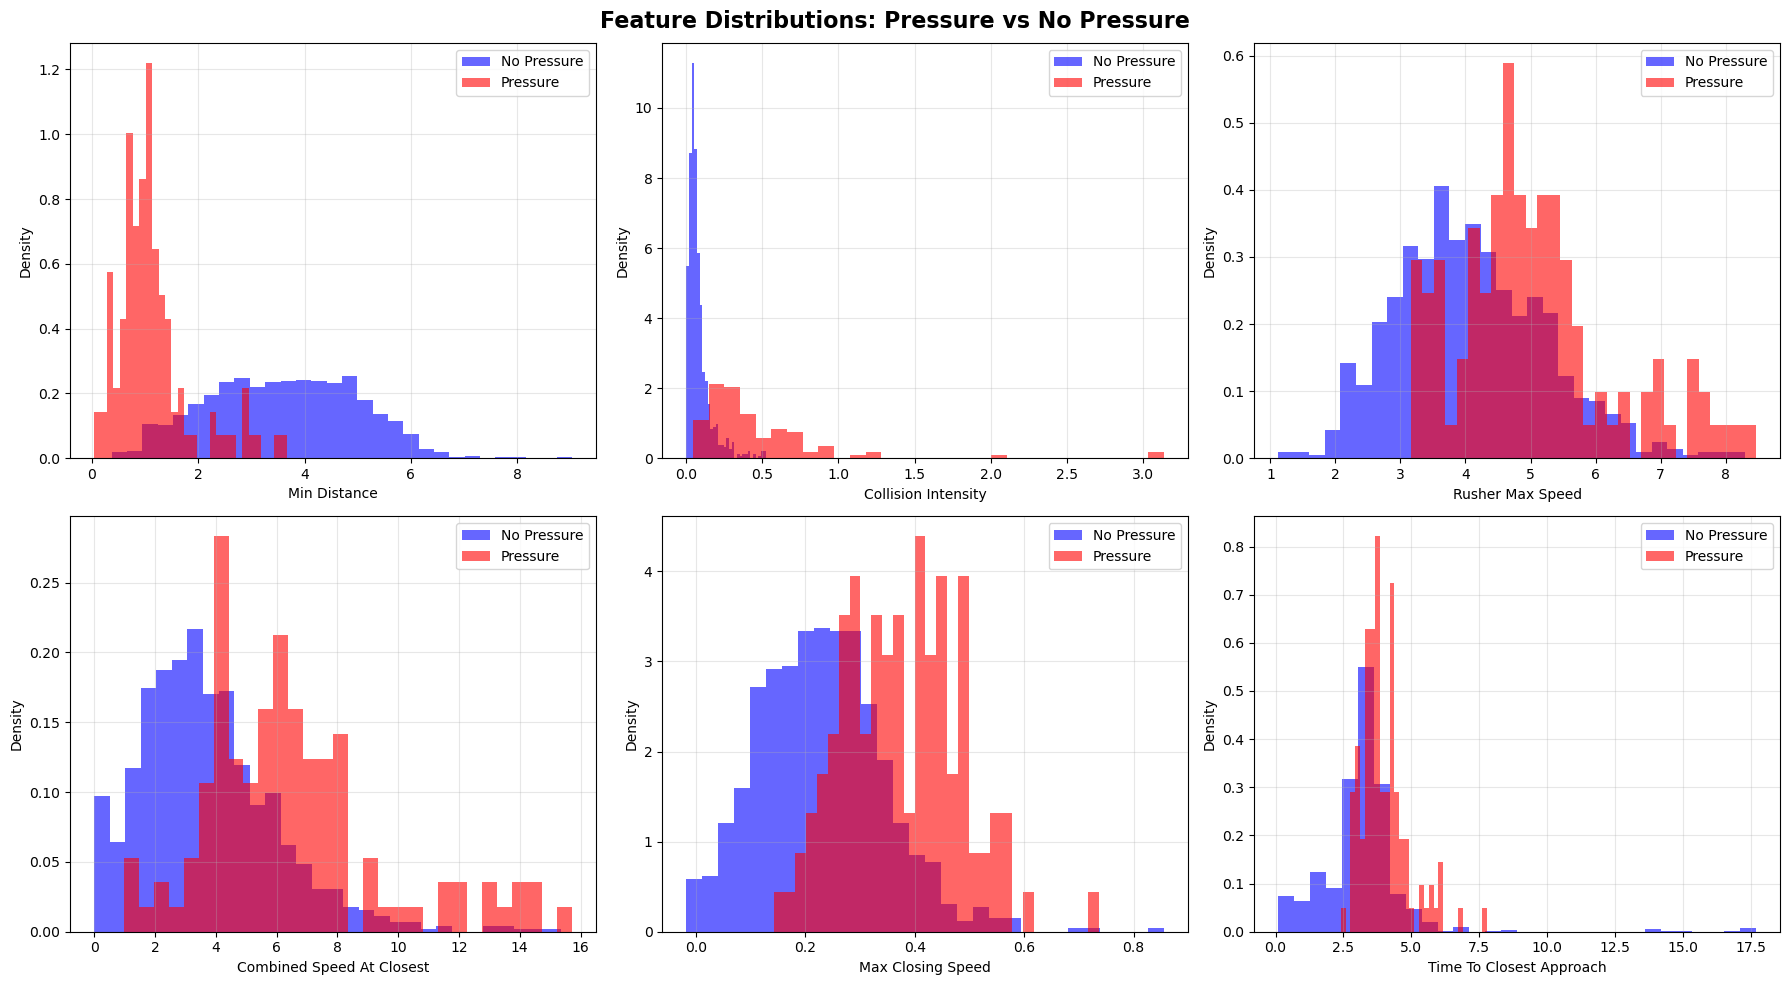

In [10]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions: Pressure vs No Pressure', fontsize=16, fontweight='bold')

for idx, feature in enumerate(key_features):
    if feature not in features_df.columns:
        continue
        
    ax = axes[idx // 3, idx % 3]
    
    pressure_data = features_df[features_df['generated_pressure'] == 1][feature].dropna()
    no_pressure_data = features_df[features_df['generated_pressure'] == 0][feature].dropna()
    
    ax.hist(no_pressure_data, bins=30, alpha=0.6, label='No Pressure', color='blue', density=True)
    ax.hist(pressure_data, bins=30, alpha=0.6, label='Pressure', color='red', density=True)
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: feature_distributions.png")
plt.show()

## 8. Save Processed Features

In [11]:
# Save to CSV
output_file = 'pass_rush_features_week1.csv'
features_df.to_csv(output_file, index=False)

print("="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)
print(f"✅ Saved {len(features_df):,} samples to: {output_file}")
print(f"✅ Total features: {len(features_df.columns)}")
print(f"\nFeature categories:")
print(f"  - Distance features: 4")
print(f"  - Speed features: 6")
print(f"  - Acceleration features: 6")
print(f"  - Relative motion: 3")
print(f"  - Orientation: 4")
print(f"  - Temporal: 3")
print(f"  - Collision intensity: 3")
print(f"  - Play context: 6")
print(f"  - Metadata: 9")
print(f"\nClass balance:")
print(f"  Pressure: {features_df['generated_pressure'].sum():,} ({features_df['generated_pressure'].mean()*100:.2f}%)")
print(f"  No Pressure: {(features_df['generated_pressure']==0).sum():,} ({(features_df['generated_pressure']==0).mean()*100:.2f}%)")

FEATURE ENGINEERING COMPLETE
✅ Saved 1,000 samples to: pass_rush_features_week1.csv
✅ Total features: 45

Feature categories:
  - Distance features: 4
  - Speed features: 6
  - Acceleration features: 6
  - Relative motion: 3
  - Orientation: 4
  - Temporal: 3
  - Collision intensity: 3
  - Play context: 6
  - Metadata: 9

Class balance:
  Pressure: 115 (11.50%)
  No Pressure: 885 (88.50%)


## 9. Feature Correlation Analysis

TOP 15 FEATURES BY CORRELATION WITH PRESSURE
generated_pressure           1.000000
pff_hurry                    0.834598
weighted_closing_speed       0.615495
collision_intensity          0.576380
collision_intensity_raw      0.576380
min_distance                 0.510048
pff_hit                      0.425637
max_closing_speed            0.377195
combined_speed_at_closest    0.342627
avg_closing_speed            0.318182
avg_distance                 0.301100
qb_speed_at_closest          0.296109
rusher_speed_at_closest      0.294864
rusher_avg_speed             0.290865
pff_sack                     0.264367
rusher_max_speed             0.258268
Name: generated_pressure, dtype: float64

✅ Saved: feature_correlations.png


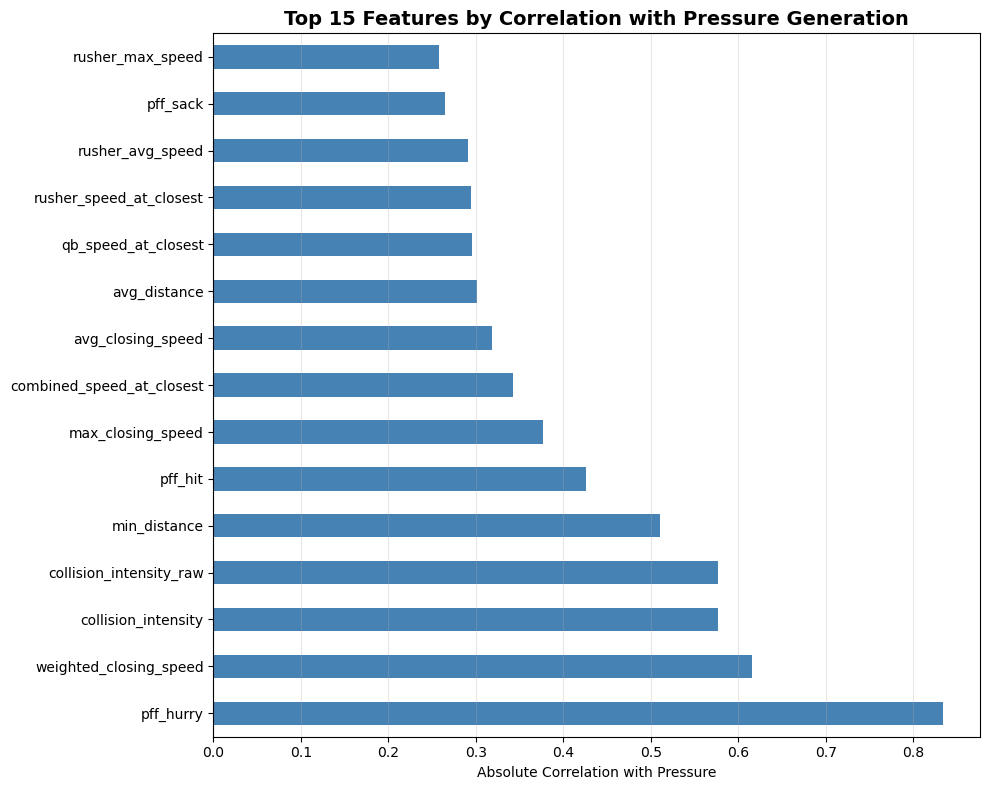

In [12]:
# Calculate correlations with target variable
numeric_features = features_df.select_dtypes(include=[np.number]).columns
correlations = features_df[numeric_features].corr()['generated_pressure'].abs().sort_values(ascending=False)

print("="*70)
print("TOP 15 FEATURES BY CORRELATION WITH PRESSURE")
print("="*70)
print(correlations.head(16))  # 16 because first is target itself

# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 8))
top_corr = correlations.head(16).iloc[1:]  # Exclude target itself
top_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Absolute Correlation with Pressure')
ax.set_title('Top 15 Features by Correlation with Pressure Generation', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: feature_correlations.png")
plt.show()

## 10. Next Steps

Now that we have engineered features for Week 1, the next steps are:

1. **Process all weeks** (1-8) to get full dataset (~36k samples)
2. **Feature selection** - identify most predictive features
3. **Model training** - build pressure prediction models:
   - Logistic Regression (baseline)
   - Random Forest
   - XGBoost
   - SVM
4. **Handle class imbalance** - SMOTE, class weights, etc.
5. **Model evaluation** - precision, recall, F1, ROC-AUC
6. **Feature importance analysis** - which collision features matter most?

**Key Finding**: Similar to punt analytics, collision intensity appears to be a strong predictor!

In [13]:
print("\n" + "="*70)
print("✅ FEATURE ENGINEERING NOTEBOOK COMPLETE!")
print("="*70)
print("\nReady for modeling phase.")


✅ FEATURE ENGINEERING NOTEBOOK COMPLETE!

Ready for modeling phase.
